In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import isolearn.keras as iso

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from aparent.predictor import *


Using TensorFlow backend.


In [2]:
#Load base APARENT model and input encoder

aparent_model = load_model('../saved_models/aparent_large_lessdropout_all_libs_no_sampleweights.h5')
aparent_encoder = get_aparent_encoder(lib_bias=4)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
#Example: pA sites from APADB (gene = PSMC6) and some non-pA repeat sequence inbetween

#Proximal and Distal PAS Sequences
seq_prox = 'AGATAGTGGTATAAGAAAGCATTTCTTATGACTTATTTTGTATCATTTGTTTTCCTCATCTAAAAAGTTGAATAAAATCTGTTTGATTCAGTTCTCCTACATATATATTCTTGTCTTTTCTGAGTATATTTACTGTGGTCCTTTAGGTTCTTTAGCAAGTAAACTATTTGATAACCCAGATGGATTGTGGATTTTTGAATATTAT'
seq_dist = 'TGGATTGTGGATTTTTGAATATTATTTTAAAATAGTACACATACTTAATGTTCATAAGATCATCTTCTTAAATAAAACATGGATGTGTGGGTATGTCTGTACTCCTCCTTTCAGAAAGTGTTTACATATTCTTCATCTACTGTGATTAAGCTCATTGTTGGTTAATTGAAAATATACATGCACATCCATAACTTTTTAAAGAGTA'

seq = (seq_prox + 'GATTGTGGATTTTTGAGTATTATTTTATTATTGTTCGCAT' * 30 + seq_dist)

print("len(seq) = " + str(len(seq)))


len(seq) = 1610


In [16]:
#Step 1: Detect peaks by scanning APARENT across the sequence (strided).

peak_ixs, polya_profile = find_polya_peaks(
    aparent_model,
    aparent_encoder,
    seq,
    sequence_stride=5,
    conv_smoothing=True,
    peak_min_height=0.01,
    peak_min_distance=50,
    peak_prominence=(0.01, None)
)

print("Peak positions = " + str(peak_ixs))
print("PolyA profile shape = " + str(polya_profile.shape))


Peak positions = [91, 177, 1497]
PolyA profile shape = (1610,)


In [18]:
#Step 2: Score the pA signals at the peak intensity positions across the sequence.

peak_iso_scores = score_polya_peaks(
    aparent_model,
    aparent_encoder,
    seq,
    peak_ixs,
    sequence_stride=1,
    strided_agg_mode='max',
    iso_scoring_mode='both',
    score_unit='log'
)

print("Peak PAS scores (log odds) = " + str(peak_iso_scores))


Peak PAS scores (log odds) = [2.413, 0.965, 1.688]


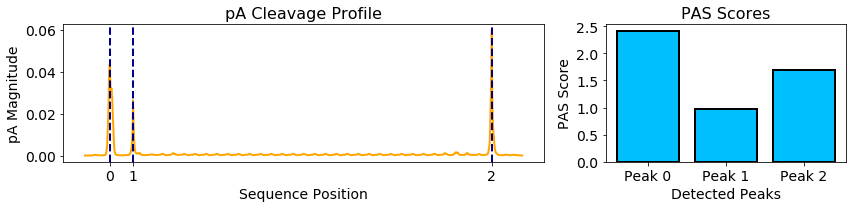

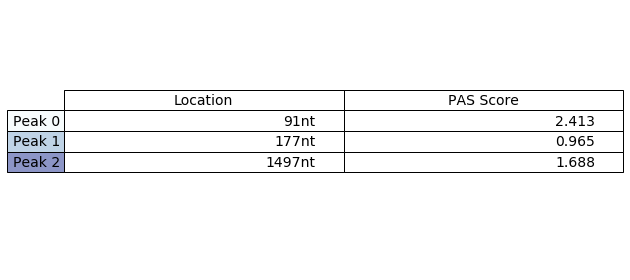

In [19]:
#Finally plot the predicted pA profile, annotate the peaks and plot the predicted PAS scores.

f, ax = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={'width_ratios': [2, 1]})

ax[0].plot(np.arange(len(seq)), polya_profile, linewidth=2, color='orange')

for pos in peak_ixs :
    ax[0].axvline(x=pos, ymin=0, linewidth=2, color='darkblue', linestyle='--')

plt.sca(ax[0])

plt.title("pA Cleavage Profile", fontsize=16)

#plt.xticks(fontsize=14)
peak_names = [str(i) for i in np.arange(len(peak_iso_scores), dtype=np.int)]

plt.xticks(peak_ixs, peak_names, fontsize=14)

plt.yticks(fontsize=14)

plt.xlabel("Sequence Position", fontsize=14)
plt.ylabel("pA Magnitude", fontsize=14)

ax[1].bar(np.arange(len(peak_iso_scores)), peak_iso_scores, color='deepskyblue', edgecolor='black', linewidth=2)

plt.sca(ax[1])

plt.title("PAS Scores", fontsize=16)

peak_names = ["Peak " + str(i) for i in np.arange(len(peak_iso_scores), dtype=np.int)]

plt.xticks(np.arange(len(peak_iso_scores)), peak_names, fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Detected Peaks", fontsize=14)
plt.ylabel("PAS Score", fontsize=14)

plt.tight_layout()
plt.show()

peak_rows = []
peak_info = []
for peak_i, peak_ix in enumerate(peak_ixs) :
    peak_rows.append("Peak " + str(peak_i))
    peak_info.append([
        str(peak_ix) + "nt",
        peak_iso_scores[peak_i]
    ])

f = plt.figure(figsize=(6, 4))

colors = plt.cm.BuPu(np.linspace(0, 0.5, len(peak_rows)))
table = plt.table(cellText=peak_info, rowLabels=peak_rows, rowColours=colors, colLabels=["Location", "PAS Score"], loc='center')

table.set_fontsize(14)
table.scale(1.5, 1.5)

plt.axis('tight')
plt.axis('off')

plt.tight_layout()
plt.show()
